Análisis del DataFrame obtenido mediante YahooFinance. 
Objetivo: Identificar las variables más propensas a influir en el valor de la acción.

In [370]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [371]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [389]:
def graph_prediction(real, prediction):
    real_date = real['Date']
    real_close = real['Close']

    plt.plot(real_date[0:len(prediction)], real_close[0:len(prediction)], color='red', label='Valor real de la acción')
    plt.plot(real_date[0:len(prediction)], prediction, color='blue', label='Predicción de la acción')
    
    # Establecer las etiquetas de las fechas en el eje x
    plt.xticks(rotation=45)
    
    plt.ylim(1.1 * np.min(prediction) / 2, 1.1 * np.max(prediction))
    plt.xlabel('Fecha')
    plt.ylabel("Valor de la Acción")
    plt.legend()
    plt.grid(True)
    plt.show()

In [373]:
ticker = yf.Ticker("AAPL")
info = ticker.info
 
data = yf.download("AAPL", start='2010-07-13', end='2023-10-01')
df = pd.DataFrame(data)
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df.dropna(subset=['SMA_10'], inplace=True)
df.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [374]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_10
3314,2023-09-25,174.199997,176.970001,174.149994,176.080002,176.080002,46172700,175.859001
3315,2023-09-26,174.820007,175.199997,171.660004,171.960007,171.960007,64588900,175.425002
3316,2023-09-27,172.619995,173.039993,169.050003,170.429993,170.429993,66921800,175.047000
3317,2023-09-28,169.339996,172.029999,167.619995,170.690002,170.690002,56294400,174.542000
3318,2023-09-29,172.020004,173.070007,170.339996,171.210007,171.210007,51814200,174.162001


In [375]:
# Extraemos los datos de la media movil hasta el 2022-09-31 para el entrenamiento, y del 2022-10-01 en adelante para la validación
train_set = df[df['Date'] <= '2022-09-30']
validate_set = df[df['Date'] >= '2022-10-01']
# Eliminamos las columnas innecesarias
train_set.drop(columns=["Open", "High", "Low", "Adj Close", "Volume", "SMA_10"], inplace=True)
validate_set.drop(columns=["Open", "High", "Low", "Adj Close", "Volume", "SMA_10"], inplace=True)

print(train_set)
print(validate_set)

           Date       Close
0    2010-07-26    9.260000
1    2010-07-27    9.431429
2    2010-07-28    9.320000
3    2010-07-29    9.218214
4    2010-07-30    9.187500
...         ...         ...
3064 2022-09-26  150.770004
3065 2022-09-27  151.759995
3066 2022-09-28  149.839996
3067 2022-09-29  142.479996
3068 2022-09-30  138.199997

[3069 rows x 2 columns]
           Date       Close
3069 2022-10-03  142.449997
3070 2022-10-04  146.100006
3071 2022-10-05  146.399994
3072 2022-10-06  145.429993
3073 2022-10-07  140.089996
...         ...         ...
3314 2023-09-25  176.080002
3315 2023-09-26  171.960007
3316 2023-09-27  170.429993
3317 2023-09-28  170.690002
3318 2023-09-29  171.210007

[250 rows x 2 columns]


C:\Users\agusm\AppData\Local\Temp\ipykernel_12736\2002442084.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.drop(columns=["Open", "High", "Low", "Adj Close", "Volume", "SMA_10"], inplace=True)
C:\Users\agusm\AppData\Local\Temp\ipykernel_12736\2002442084.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate_set.drop(columns=["Open", "High", "Low", "Adj Close", "Volume", "SMA_10"], inplace=True)


In [376]:
# Establecer la columna "Date" como índice
train_set.set_index('Date', inplace=True)
validate_set.set_index('Date', inplace=True)

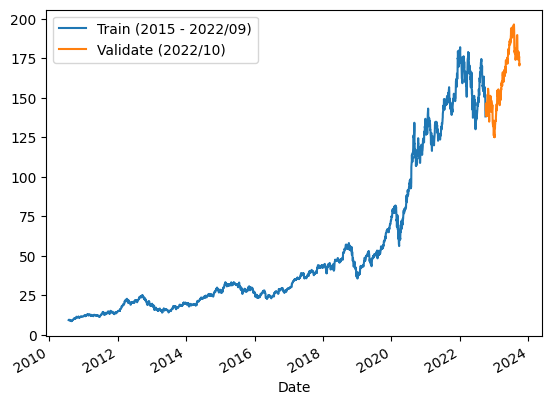

In [377]:
# Gráfico para observar los datos de entrenamiento y validación.
train_set["Close"].plot(legend=True)
validate_set["Close"].plot(legend=True)
plt.legend(['Train (2015 - 2022/09)', 'Validate (2022/10)'])
plt.show()

In [378]:
# Normalizamos los datos de entrenamiento entre 0-1
sc = MinMaxScaler(feature_range=(0,1))
train_set_normal = sc.fit_transform(train_set)

In [379]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (es el resultado de la predicción a partir de esos "time_step" datos). Se conforma de esta manera el set de entrenamiento.
time_step = 60
x_train = []
y_train = []
m = len(train_set_normal)

for i in range(time_step, m):
    # Datos: 0-time_step; 1-time_step+1; 2-time_step+2; etc.
    x_train.append(train_set_normal[i-time_step:i, 0])

    y_train.append(train_set_normal[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [380]:
# Defino el modelo de entrada y salida de la red
dim_entry = (x_train.shape[1], 1)
dim_out = 1
na = 50

In [381]:
# Defino la red secuencial
model = Sequential()
model.add(LSTM(units=na, input_shape=dim_entry, activation="tanh"))
model.add(Dense(units=dim_out))
model.compile(optimizer='rmsprop', loss='mse')
model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
95/95 [==============================] - 3s 12ms/step - loss: 0.0102
Epoch 2/50
95/95 [==============================] - 1s 12ms/step - loss: 0.0011
Epoch 3/50
95/95 [==============================] - 1s 12ms/step - loss: 7.0727e-04
Epoch 4/50
95/95 [==============================] - 1s 12ms/step - loss: 5.0318e-04
Epoch 5/50
95/95 [==============================] - 1s 12ms/step - loss: 4.4714e-04
Epoch 6/50
95/95 [==============================] - 1s 12ms/step - loss: 3.2908e-04
Epoch 7/50
95/95 [==============================] - 1s 12ms/step - loss: 3.0799e-04
Epoch 8/50
95/95 [==============================] - 1s 12ms/step - loss: 2.9295e-04
Epoch 9/50
95/95 [==============================] - 1s 12ms/step - loss: 2.7801e-04
Epoch 10/50
95/95 [==============================] - 1s 12ms/step - loss: 2.4098e-04
Epoch 11/50
95/95 [==============================] - 1s 12ms/step - loss: 2.2127e-04
Epoch 12/50
95/95 [==============================] - 1s 12ms/step - loss: 2.3253e-

In [382]:
# Preparo los datos de prueba
x_test = validate_set.values
x_test = sc.transform(x_test)

c:\Users\agusm\OneDrive\Escritorio\LilMarcian-GitHub\LilMarcian\env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [383]:
X_test = []
for i in range(time_step, len(x_test)):
    X_test.append(x_test[i-time_step:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [384]:
# Realizo la predicción
prediction = model.predict(X_test)
prediction = sc.inverse_transform(prediction)

6/6 [==============================] - 0s 5ms/step


In [387]:
graph_prediction(validate_set.reset_index(), prediction)

InvalidIndexError: (1, slice(0, 190, None))